In [1]:
!mamba install pandas numpy 
%pip install --upgrade openpyxl

import pandas as pd
import numpy as np
import openpyxl

mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, pandas
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 0.9272000000001863 seconds
  Name                          Version                       Build                         Channel                       
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
+ pandas                        2.3.3                         np22py313h9d9dc1e_0           emscripten-forge              
+ python-tzdata                 2025.3                        pyhd8ed1ab_0                  conda-forge                   
- pip                           25.3                          pyh145f28c_0                  conda-forge                   
mambajs 0.19.13

Process pip requirements ...



## MEAN-VARIANCE OPTIMIZATION

####
#1. Summary Statistics
####

In [9]:
# -----------------------------
# Load data
# -----------------------------
df = pd.read_excel(
    "/multi_asset_etf_data.xlsx",
    sheet_name="excess returns"
)

# Drop QAI if present (not used in analysis)
df = df.drop(columns=["QAI"], errors="ignore")

# Select first 10 assets, excluding Date and SHV (cash proxy)
assets = [c for c in df.columns if c not in ["Date", "SHV"]][:10]

# Convert to numeric and remove missing observations
excess = df[assets].apply(pd.to_numeric, errors="coerce").dropna()

# -----------------------------
# Summary statistics (annualized)
# -----------------------------
mean = excess.mean() * 12
vol = excess.std(ddof=1) * np.sqrt(12)
sharpe = mean / vol

# Combine into results table
results = pd.DataFrame({
    "Mean (ann.)": mean,
    "Vol (ann.)": vol,
    "Sharpe": sharpe
})

# Sort by Sharpe ratio
results_sorted = results.sort_values("Sharpe", ascending=False)

# -----------------------------
# Best / Worst Sharpe
# -----------------------------
print("\nBest Sharpe asset:", sharpe.idxmax(), "Sharpe:", round(sharpe.max(), 3))
print("\nWorst Sharpe asset:", sharpe.idxmin(), "Sharpe:", round(sharpe.min(), 3))

# Display formatted table
results_sorted.style.format({
    "Mean (ann.)": "{:.1%}",
    "Vol (ann.)": "{:.1%}",
    "Sharpe": "{:.2f}"
})



Best Sharpe asset: SPY Sharpe: 0.897

Worst Sharpe asset: BWX Sharpe: -0.093


,Mean (ann.),Vol (ann.),Sharpe
SPY,12.8%,14.3%,0.90
HYG,4.1%,7.6%,0.54
IYR,7.5%,16.9%,0.44
PSP,9.3%,21.3%,0.43
EFA,6.2%,15.1%,0.41
TIP,2.1%,5.1%,0.40
IEF,1.6%,6.3%,0.26
EEM,2.9%,17.6%,0.17
DBC,-0.5%,16.7%,-0.03
BWX,-0.8%,8.3%,-0.09


####
#2. Descriptive Analysis
####

Highest correlation pair: ('EFA', 'PSP') Corr: 0.895
Lowest correlation pair: ('DBC', 'IEF') Corr: -0.3

TIPS vs Bonds (annualized mean excess return):
TIP (TIPS): 2.05%
Domestic bonds (IEF): 1.64%
Foreign bonds (BWX): -0.77%

Outperformance (annualized mean):
TIP - IEF: 0.41%
TIP - BWX: 2.82%


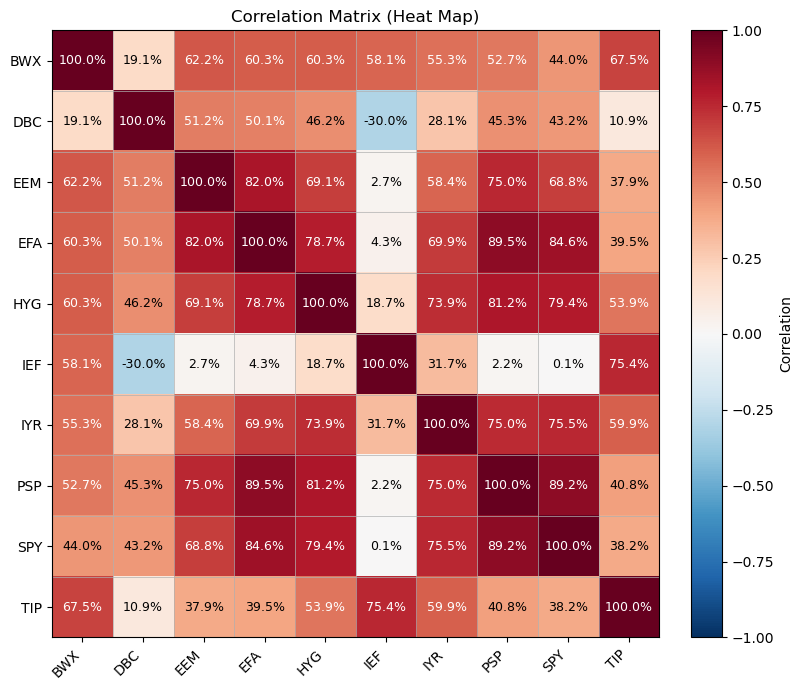

In [17]:
import matplotlib.pyplot as plt

# -----------------------------
# Clean column names + pick assets
# -----------------------------
df.columns = df.columns.astype(str).str.strip()

asset_cols = []
for c in df.columns:
    if c not in ["Date", "SHV", "QAI"]:
        asset_cols.append(c)

assets = asset_cols[:10]

# Convert to numeric and remove missing values
rets = df[assets].apply(pd.to_numeric, errors="coerce").dropna()

# -----------------------------
# Correlation matrix
# -----------------------------
corr = rets.corr()

# Display as a nicely formatted table
corr.style.format("{:.3f}")

# -----------------------------
# Highest / Lowest correlation pair
# -----------------------------
best_pair = None
best_val = -1e9
worst_pair = None
worst_val = 1e9

cols = corr.columns

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):   # upper triangle only
        val = corr.iloc[i, j]

        if pd.notna(val):
            if val > best_val:
                best_val = float(val)
                best_pair = (cols[i], cols[j])
            if val < worst_val:
                worst_val = float(val)
                worst_pair = (cols[i], cols[j])

print("Highest correlation pair:", best_pair, "Corr:", round(best_val, 3))
print("Lowest correlation pair:", worst_pair, "Corr:", round(worst_val, 3))

# -----------------------------
# TIPS vs domestic/foreign bonds (annualized mean excess return)
# -----------------------------
need = ["TIP", "IEF", "BWX"]

if all(ticker in rets.columns for ticker in need):
    tip_ann = rets["TIP"].mean() * 12
    ief_ann = rets["IEF"].mean() * 12
    bwx_ann = rets["BWX"].mean() * 12

    print("\nTIPS vs Bonds (annualized mean excess return):")
    print(f"TIP (TIPS): {tip_ann:.2%}")
    print(f"Domestic bonds (IEF): {ief_ann:.2%}")
    print(f"Foreign bonds (BWX): {bwx_ann:.2%}")

    print("\nOutperformance (annualized mean):")
    print(f"TIP - IEF: {(tip_ann - ief_ann):.2%}")
    print(f"TIP - BWX: {(tip_ann - bwx_ann):.2%}")
else:
    print("\nTIP/IEF/BWX not all available in the selected assets list. (Check your 'assets' selection.)")

import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Correlation heat map (red/blue + % annotations)
# -----------------------------
corr_vals = corr.values
labels = corr.columns.tolist()
n = len(labels)

fig, ax = plt.subplots(figsize=(9, 7))

# Diverging red/blue colormap with symmetric scale from -1 to +1
im = ax.imshow(corr_vals, vmin=-1, vmax=1, cmap="RdBu_r")

# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Correlation", rotation=90)

# Ticks/labels
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)

ax.set_title("Correlation Matrix (Heat Map)")

# Add light gridlines to separate cells (helps readability)
ax.set_xticks(np.arange(-.5, n, 1), minor=True)
ax.set_yticks(np.arange(-.5, n, 1), minor=True)
ax.grid(which="minor", linestyle="-", linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

# Annotate each cell with correlation as a percent (e.g., 35.2%)
# Using white/black text depending on background intensity for readability
for i in range(n):
    for j in range(n):
        val = corr_vals[i, j]
        text_color = "white" if abs(val) > 0.5 else "black"
        ax.text(j, i, f"{val*100:.1f}%",
                ha="center", va="center", color=text_color, fontsize=9)

plt.tight_layout()
plt.show()

####
#3. The MV Frontier
####

In [18]:
# -----------------------------
# Tangency portfolio (Mean-Variance)
# -----------------------------
R = df[assets].apply(pd.to_numeric, errors="coerce").dropna()

# Annualized inputs
mu = R.mean() * 12
cov = R.cov() * 12

# Solve cov * w_raw = mu  (equivalent to inv(cov) @ mu but more stable)
raw_w = np.linalg.solve(cov.values, mu.values)

# Normalize to sum to 1 (tangency weights)
w = raw_w / raw_w.sum()
w = pd.Series(w, index=assets)

# -----------------------------
# Display tangency weights 
# -----------------------------
weights_table = pd.DataFrame({
    "Weight": w
}).sort_values("Weight", ascending=False)

weights_table.style.format({"Weight": "{:.2%}"})

# -----------------------------
# Compare rankings: weights vs Sharpe ratios
# -----------------------------
asset_vol = pd.Series(np.sqrt(np.diag(cov.values)), index=assets)
sharpe = mu / asset_vol

w_rank = w.sort_values(ascending=False)
sh_rank = sharpe.sort_values(ascending=False)

print("Weight ranking (highest to lowest):")
print(list(w_rank.index))

print("\nSharpe ranking (highest to lowest):")
print(list(sh_rank.index))

# -----------------------------
# Tangency portfolio stats (annualized)
# -----------------------------
port_mean = float(w @ mu)
port_var = float(w.values @ cov.values @ w.values)
port_vol = float(np.sqrt(port_var))
port_sharpe = port_mean / port_vol

print("\nTangency portfolio stats (annualized):")
print(f"Mean  : {port_mean:.2%}")
print(f"Vol   : {port_vol:.2%}")
print(f"Sharpe: {port_sharpe:.3f}")

# Showing a combined table for easy comparison
compare_table = pd.DataFrame({
    "Weight": w,
    "Mean (ann.)": mu,
    "Vol (ann.)": asset_vol,
    "Sharpe (ann.)": sharpe
}).sort_values("Weight", ascending=False)

compare_table.style.format({
    "Weight": "{:.2%}",
    "Mean (ann.)": "{:.1%}",
    "Vol (ann.)": "{:.1%}",
    "Sharpe (ann.)": "{:.2f}"
})

Weight ranking (highest to lowest):
['SPY', 'IEF', 'HYG', 'TIP', 'EFA', 'EEM', 'DBC', 'IYR', 'PSP', 'BWX']

Sharpe ranking (highest to lowest):
['SPY', 'HYG', 'IYR', 'PSP', 'EFA', 'TIP', 'IEF', 'EEM', 'DBC', 'BWX']

Tangency portfolio stats (annualized):
Mean  : 12.85%
Vol   : 8.75%
Sharpe: 1.469


,Weight,Mean (ann.),Vol (ann.),Sharpe (ann.)
SPY,105.96%,12.8%,14.3%,0.90
IEF,88.12%,1.6%,6.3%,0.26
HYG,29.06%,4.1%,7.6%,0.54
TIP,17.53%,2.1%,5.1%,0.40
EFA,6.87%,6.2%,15.1%,0.41
EEM,2.64%,2.9%,17.6%,0.17
DBC,-7.16%,-0.5%,16.7%,-0.03
IYR,-24.66%,7.5%,16.9%,0.44
PSP,-33.30%,9.3%,21.3%,0.43
BWX,-85.06%,-0.8%,8.3%,-0.09


####
#4. TIPS
####

In [19]:
# -----------------------------
# Tangency portfolio (Mean-Variance)
# -----------------------------
R = df[assets].apply(pd.to_numeric, errors="coerce").dropna()

# Annualized inputs
mu = R.mean() * 12
cov = R.cov() * 12

# Solve cov * w_raw = mu  (equivalent to inv(cov) @ mu but more stable)
raw_w = np.linalg.solve(cov.values, mu.values)

# Normalize to sum to 1 (tangency weights)
w = raw_w / raw_w.sum()
w = pd.Series(w, index=assets)

# -----------------------------
# Display tangency weights nicely
# -----------------------------
weights_table = pd.DataFrame({
    "Weight": w
}).sort_values("Weight", ascending=False)

weights_table.style.format({"Weight": "{:.2%}"})

# -----------------------------
# Compare rankings: weights vs Sharpe ratios
# -----------------------------
asset_vol = pd.Series(np.sqrt(np.diag(cov.values)), index=assets)
sharpe = mu / asset_vol

w_rank = w.sort_values(ascending=False)
sh_rank = sharpe.sort_values(ascending=False)

print("Weight ranking (highest to lowest):")
print(list(w_rank.index))

print("\nSharpe ranking (highest to lowest):")
print(list(sh_rank.index))

# Optional: show a combined table for easy comparison
compare_table = pd.DataFrame({
    "Weight": w,
    "Mean (ann.)": mu,
    "Vol (ann.)": asset_vol,
    "Sharpe (ann.)": sharpe
}).sort_values("Weight", ascending=False)

compare_table.style.format({
    "Weight": "{:.2%}",
    "Mean (ann.)": "{:.1%}",
    "Vol (ann.)": "{:.1%}",
    "Sharpe (ann.)": "{:.2f}"
})

# -----------------------------
# Tangency portfolio stats (annualized)
# -----------------------------
port_mean = float(w @ mu)
port_var = float(w.values @ cov.values @ w.values)
port_vol = float(np.sqrt(port_var))
port_sharpe = port_mean / port_vol

print("\nTangency portfolio stats (annualized):")
print(f"Mean  : {port_mean:.2%}")
print(f"Vol   : {port_vol:.2%}")
print(f"Sharpe: {port_sharpe:.3f}")

Weight ranking (highest to lowest):
['SPY', 'IEF', 'HYG', 'TIP', 'EFA', 'EEM', 'DBC', 'IYR', 'PSP', 'BWX']

Sharpe ranking (highest to lowest):
['SPY', 'HYG', 'IYR', 'PSP', 'EFA', 'TIP', 'IEF', 'EEM', 'DBC', 'BWX']

Tangency portfolio stats (annualized):
Mean  : 12.85%
Vol   : 8.75%
Sharpe: 1.469


## ALLOCATIONS

In [34]:
MU_TARGET = 0.01  # monthly target mean excess return

# monthly expected excess returns (do NOT annualize here)
mu_m = R.mean()

def rescale_to_target_mean(mu_m, w, mu_target):
    # scale factor k so that (k*w)' mu = mu_target
    current = float(mu_m @ w)
    k = mu_target / current
    return w * k

# rescale each portfolio to target monthly mean = 0.01
w_ew = rescale_to_target_mean(mu_m, w_ew, MU_TARGET)
w_rp = rescale_to_target_mean(mu_m, w_rp, MU_TARGET)
w_mv = rescale_to_target_mean(mu_m, w_mv, MU_TARGET)


# -----------------------------
# Performance statistics (annualized)
# -----------------------------
def perf_stats_annual(R, w):
    rp = R @ w                     # monthly portfolio returns

    mean_m = float(rp.mean())
    vol_m  = float(rp.std(ddof=1))
    sharpe_m = mean_m / vol_m

    mean_a = mean_m * 12
    vol_a  = vol_m * np.sqrt(12)
    sharpe_a = sharpe_m * np.sqrt(12)

    min_m = float(rp.min())
    max_m = float(rp.max())

    return mean_a, vol_a, sharpe_a, min_m, max_m


# -----------------------------
# Build results table
# -----------------------------
results = pd.DataFrame(
    index=["EW", "RP", "MV"],
    columns=["Mean (ann.)", "Vol (ann.)", "Sharpe (ann.)", "Min (monthly)", "Max (monthly)"],
    dtype=float
)

results.loc["EW"] = perf_stats_annual(R, w_ew)
results.loc["RP"] = perf_stats_annual(R, w_rp)
results.loc["MV"] = perf_stats_annual(R, w_mv)

# -----------------------------
# Display as a clean table
# -----------------------------
results.style.format({
    "Mean (ann.)": "{:.2%}",
    "Vol (ann.)": "{:.2%}",
    "Sharpe (ann.)": "{:.3f}",
    "Min (monthly)": "{:.2%}",
    "Max (monthly)": "{:.2%}",
})


,Mean (ann.),Vol (ann.),Sharpe (ann.),Min (monthly),Max (monthly)
EW,12.00%,26.92%,0.446,-32.47%,22.15%
RP,12.00%,26.39%,0.455,-27.98%,19.28%
MV,12.00%,8.17%,1.469,-4.74%,7.69%


In [35]:
from IPython.display import display, Markdown

def show_weights(w, title):
    dfw = pd.DataFrame({"Weight": w}).sort_values("Weight", ascending=False)
    display(Markdown(f"### {title} weights"))
    display(dfw.style.format({"Weight": "{:.2%}"}))

show_weights(w_ew, "EW")
show_weights(w_rp, "RP")
show_weights(w_mv, "MV")


### EW weights

,Weight
BWX,26.55%
DBC,26.55%
EEM,26.55%
EFA,26.55%
HYG,26.55%
IEF,26.55%
IYR,26.55%
PSP,26.55%
SPY,26.55%
TIP,26.55%


### RP weights

,Weight
TIP,141.81%
IEF,92.06%
HYG,64.27%
BWX,54.06%
SPY,18.16%
EFA,16.27%
DBC,13.36%
IYR,13.02%
EEM,11.94%
PSP,8.14%


### MV weights

,Weight
SPY,98.94%
IEF,82.28%
HYG,27.13%
TIP,16.37%
EFA,6.41%
EEM,2.47%
DBC,-6.69%
IYR,-23.02%
PSP,-31.09%
BWX,-79.42%
